### Attention Fooling Around

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
import math
from tqdm import tqdm
import random
%matplotlib inline

In [3]:
words = open('./names.txt').read().splitlines()
words[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [6]:
chars = sorted(list(set(''.join(words)))) #lol
token_lookup = {c: i+1 for i, c in enumerate(chars)}
token_lookup['.'] = 0
char_lookup = {i:c for c, i in token_lookup.items()}
TOTAL_TOKENS = len(char_lookup.keys())

In [7]:
# build the dataset

BLOCK_SIZE = 8 # context size to give the model in order to predict the next character

def build_dataset(corpus, block_size, codebook, padding_char="."):
    X, Y = [], []
    for word in corpus:
        start_padding = padding_char * block_size
        padded_word = f"{start_padding}{word}."
        tokenized_word = [codebook[c] for c in padded_word]
        for i in range(len(tokenized_word)-block_size):
            X.append(tokenized_word[i:i+block_size])
            Y.append(tokenized_word[i+block_size])
        
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    
    print(X.shape, Y.shape)
    
    return X, Y


random.shuffle(words)

n1 = int(len(words)*0.8)
n2 = int(len(words)*0.9)

x_train, y_train = build_dataset(words[:n1], BLOCK_SIZE, token_lookup)
x_valid, y_valid = build_dataset(words[n1:n2], BLOCK_SIZE, token_lookup)
x_test, y_test = build_dataset(words[n2:], BLOCK_SIZE, token_lookup)

torch.Size([182523, 8]) torch.Size([182523])
torch.Size([22861, 8]) torch.Size([22861])
torch.Size([22762, 8]) torch.Size([22762])


In [95]:
class ScaledDotProductAttention(nn.Module):
    
    def __init__(self, in_dims, hidden_dims, context_size):
        
        super(ScaledDotProductAttention, self).__init__()
        
        self.queries = nn.Linear(in_dims, hidden_dims)
        self.keys = nn.Linear(in_dims, hidden_dims)
        self.values = nn.Linear(in_dims, hidden_dims)
        
        self.dk_scale = torch.sqrt(in_dims if isinstance(in_dims, torch.Tensor) else torch.tensor(in_dims))
        
        self.projection = nn.Linear(context_size * hidden_dims, hidden_dims)
        
    def forward(self, x):
        
        q_state = self.queries(x)
        k_state = self.keys(x).permute(0, 2, 1) # transpose
        v_state = self.values(x)
        
        qk_state = ((q_state @ k_state) / self.dk_scale).permute(0, 1, 2)
        qk_state = torch.softmax(qk_state, -1)
        
        attention = qk_state @ v_state
        
        out = self.projection(attention.view(attention.shape[0],-1)) # this might be wrong!
        
        return out
    
class Model(nn.Module):
    
    def __init__(self, token_size:int, embedding_dims:int, hidden_dims:int, block_size:int):
        
        super(Model, self).__init__()
        
        self.hidden_dims = hidden_dims
        
        self.embedding_layer = nn.Embedding(token_size, embedding_dims)
        self.attention_sequence = nn.Sequential(
            ScaledDotProductAttention(embedding_dims, hidden_dims, block_size),
            nn.ReLU(),
            nn.Linear(hidden_dims, token_size)
        )
        
    def forward(self, x):
        embedding = self.embedding_layer(x)
        out = self.attention_sequence(embedding)
        return out

In [100]:
EMBEDDING_DIMS = 24
HIDDEN_DIMS = 256

model = Model(embedding_dims=EMBEDDING_DIMS, token_size=TOTAL_TOKENS, hidden_dims=HIDDEN_DIMS, block_size=BLOCK_SIZE)
print(sum(p.numel() for p in model.parameters()))

device = 'cuda:1'
steps = 10000
print_steps = 2000
BATCH_SIZE = 256

losses = []

optim = torch.optim.Adam(model.parameters())
pbar = tqdm(range(steps))

model.to(device)

for t in pbar:
    batch_ix = torch.randint(0, x_train.shape[0], (BATCH_SIZE,))
    batch = x_train[batch_ix].to(device)
    logits = model(batch)
    
    loss = F.cross_entropy(logits, y_train[batch_ix].to(device))
    losses.append(loss.item())
    pbar.set_description(desc=f'average loss: {(sum(losses[-100:])/100):.2f}')

    model.zero_grad()
    loss.backward()
    optim.step()

551331


average loss: 1.91: 100%|████████████████| 10000/10000 [00:32<00:00, 309.81it/s]


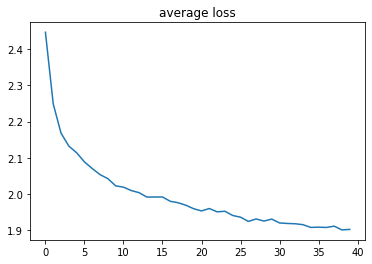

In [101]:
plt.plot(torch.tensor(losses).view(-1, 250).mean(1))
plt.title("average loss");

In [102]:
model.to('cpu')
model.train(False)

# clculate training and validation loss
@torch.no_grad()
def calc_loss(x_target, y_target):
    logits = model(x_target)
    loss = F.cross_entropy(logits, y_target)
    return loss

('train', calc_loss(x_train, y_train).item()), ('val', calc_loss(x_valid, y_valid).item())

(('train', 1.894067645072937), ('val', 2.075551986694336))

In [103]:
# sample
@torch.no_grad()
def sample():
    tokens = [0] * BLOCK_SIZE
    while True:
        cur_tokens = torch.tensor(tokens[-BLOCK_SIZE:]).unsqueeze(0)
        logits = model(cur_tokens)
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1).item()
        tokens.append(ix)
        if ix == 0:
            break
    return "".join([char_lookup[t] for t in tokens][BLOCK_SIZE:-1])

for i in range(20):
    print(sample())

aaylar
nayelle
kanling
conathen
calillia
pragabe
hingolit
hadlyn
zaye
wellary
sachan
successel
salarya
marissa
damyryn
aila
rekli
kehed
lillann
reina
